# TITLE   TITLE   TITLE

## Contents
* [Introduction](#intro)
* [Theory behind methods](#method)
* [Analysing the CryptoPunks dataset](#dataset)
* [Denoising](#denoising)
* [Conclusion](#conclusion)

## Introduction <a class="anchor" id="intro"></a>

INSERT intro her

We will use ... these libraries ... 

In [1]:
## Libraries for math and plotting
import numpy as np
import matplotlib.pyplot as plt

## Image handling, files, timing and status bar
#%pip install opencv-python 
# Required to import cv2 !!!
import cv2
import os
import time
import random
from tqdm.notebook import tqdm

## (TASK 1) Theory behind methods <a class="anchor" id="method"></a>

**SUGGESTION: we present the method/algorithm here and do the tasks a-c before implementation.**

present\
\
\
\
\

present

a) vise blabla
\
\
\
\

We will show that if $A$ is non negative and $W$ and $H$ are initialized as positive, then all iterates $W_k$ and $H_k$ are also positive. This will by done by induction:  **Hvis a er 0 blir vel W_k og H_k også 0?, så vil må vel endre formulerinen litt?**

Asssume $A$ is non negative and $W$ and $H$ are initialized as positive, and let $P(n)$ be the statement $W_k$ and $H_k$ are positive.

The hypothesis clearly holds for the base case $P(0)$, as $W_0=W$ and $H_0=H$ being positive is part of our assumptions. 

Now we assume the induction hypothesis holds for $n=k$. We have that:

$H_{k+1} ← H_k ⊙ (W^T_k A) ⊘ (W^T_k W_kH_k)$

$W_{k+1} ← W_k ⊙ (AH^T_{k+1}) ⊘ (W_kH_{k+1}H^T_{k+1})$

It is clear that $H_{k+1}$ is positive, as it is a product of $H_k$, $W_k$, $W^T_k$ and $A$, which are all positive under our assumptions and induction hypothesis. 

It follows that $W_{k+1}$ is positive, as it is also a product of only positive matrices. 

Hence the induction hypothesis holds for $n=k+1$. By induction it follows that $P(n)$ holds for all $n$ in $\mathbb{Z}^+$.


b) vise blabla
\
\
\
\
If $(W^T_k A) ⊘ (W^T_k W_kH_k)$ is a matrix of ones we see that when calculating $H_{k+1}$ we multiply every element of $H_k$ by $1$, meaning $H_{k+1}=H_k$, this is known as a fixed point. 

This is the case if $W_kH_k=A$, indeed if $W_kH_k=A$ then $(W^T_k A) ⊘ (W^T_k W_kH_k)=(W^T_k A) ⊘ (W^T_k A)$, which is clearly a matrix of ones. **Trenger vi forklare hvorfor det blir 1?**

c) vise blabla
\
\
\
\\

If either $W_0$ or $H_0$ are set to matrices containing only zeros, we can see from **ref Hk+1 Wk+1** that $H_k$ and $W_k$ converges to $0$ regardless of $A$. In other words $WH$ will never converge towards $A$, unless by chance $A$ is also a matrix of zeros.  
 

We will now implement the NMF algorithm. To test that our algorithm works we define the following matrices:

$$ 
A_1 = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix},\,\,\,\,\,
A_2 = \begin{bmatrix} 1 & 2 \\ 1 & 1 \\ 1 & 2 \end{bmatrix},\,\,\,\,\,
A_3 = \begin{bmatrix} 2 & 1 & 1 \\ 2 & 1 & 1 \\ 1 & 1 & 2 \end{bmatrix},\,\,\,\,\,
A_4 = \begin{bmatrix} 2 & 1 & 0 \\ 1 & 2 & 3 \\ 0 & 3 & 3 \end{bmatrix}.
$$

In [2]:
A1 = np.array([[1, 0],
               [0, 1]], dtype = "float")

A2 = np.array([[1, 2],
               [1, 1],
               [1, 2]], dtype = "float")

A3 = np.array([[2, 1, 1],
               [2, 1, 1],
               [1, 1, 2]], dtype = "float")

A4 = np.array([[2, 1, 0],
               [1, 2, 3],
               [0, 3, 3]], dtype = "float")

In [3]:
#d
#e
#f extend to store frobenius norm

def NMF(V, d, delta = 1e-9, maxiter = 1000, seed = 4269):
    """
    Performs maxiter iterations of the NMF algorithm described above to find 
    matrices W and H such that V ≈ WH. 
    input:
        V: (m,n) input array
        d: integer, Number of components we want to decompose V into
        delta, float, small number for safe division
        maxiter: integer, maximum number of iterations
        seed: integer, random seed
    output:
        W: (m,d) array
        H: (d,n) array
        err: array of lenght maxiter+1 with Frodenius norms ||V-W_k@H_k||
    """

    if seed != 0:
        np.random.seed(seed)
        
    # Find dimensions of V
    m = np.shape(V)[0]
    n = np.shape(V)[1]
    
    # Initialize W and H with numbers from Unif(0, 1), and rescale by factor sqrt(mean(A)/d)
    random_numbers_01 = np.random.uniform(0.0, 1.0, m*d+d*n) # we need m*d+d*n numbers
    W = np.sqrt(np.mean(V)/d) * random_numbers_01[0:m*d].reshape((m, d))
    H = np.sqrt(np.mean(V)/d) * random_numbers_01[m*d:m*d+d*n].reshape((d, n))

    # Initialize the array err for storing the Frobenius norm ||V-WH||
    err    = np.zeros(maxiter+1)
    err[0] = np.linalg.norm(V - np.dot(W, H), 'fro')
    
    # Perform the iterations
    for k in tqdm(range(maxiter), leave = False):
        H = H * np.dot(W.T, V) / (np.dot(W.T, np.dot(W, H)) + delta)
        W = W * np.dot(V, H.T) / (np.dot(W, np.dot(H, H.T)) + delta)
        err[k+1] = np.linalg.norm(V - np.dot(W, H), 'fro')
    
    return W, H, err

W1, H1, err1 = NMF(A1, 1, seed = 42)
print(f"With A = A\u2081 =\n{A1}, \nwe find W = \n{W1}, \nH = \n{H1}, \nWH = \n{np.dot(W1, H1)}.")
print(f"This gives the Frobenius norm ||A\u2081-WH|| = {err1[-1]}")

## SKAL VI GJØRE TO FOR HVER???????
# W1s, H1s, err1s = NMF(A1, 1, seed = 69)
# print(f"With A = A\u2081 =\n{A1}, \nwe find W = \n{W1s}, \nH = \n{H1s}, \nWH = \n{np.dot(W1s, H1s)}s.")
# print(f"This gives the Frobenius norm ||A\u2081-WH|| = {err1s[-1]}")

print(100*"_", "\n")

W2, H2, err2 = NMF(A2, 1, seed = 42)
print(f"With A = A\u2082 =\n{A2}, \nwe find W = \n{W2}, \nH = \n{H2}, \nWH = \n{np.dot(W2, H2)}.")
print(f"This gives the Frobenius norm ||A\u2081-WH|| = {err2[-1]}")

# NMF(A2, 1, seed = 69)

    

  0%|          | 0/1000 [00:00<?, ?it/s]

With A = A₁ =
[[1. 0.]
 [0. 1.]], 
we find W = 
[[0.26483929]
 [0.67225743]], 
H = 
[[0.50728703 1.28767706]], 
WH = 
[[0.13434954 0.34102747]
 [0.34102747 0.86565046]].
This gives the Frobenius norm ||A₁-WH|| = 1.0
____________________________________________________________________________________________________ 



  0%|          | 0/1000 [00:00<?, ?it/s]

With A = A₂ =
[[1. 2.]
 [1. 1.]
 [1. 2.]], 
we find W = 
[[1.07756663]
 [0.65765756]
 [1.07756663]], 
H = 
[[1.02104595 1.80336153]], 
WH = 
[[1.10024505 1.94324222]
 [0.67149858 1.18599434]
 [1.10024505 1.94324222]].
This gives the Frobenius norm ||A₁-WH|| = 0.4111546000651088


In [4]:
#e

d = 2

W1, H1, err1 = NMF(A1, d, seed = 42)
print(f"With A = A\u2081 =\n{A1}, \nwe find W = \n{W1}, \nH = \n{H1}, \nWH = \n{np.dot(W1, H1)}.")
print(f"This gives the Frobenius norm ||A\u2081-WH|| = {err1[-1]}")

print(100*"_", "\n")

W2, H2, err2 = NMF(A2, d, seed = 42)
print(f"With A = A\u2082 =\n{A2}, \nwe find W = \n{W2}, \nH = \n{H2}, \nWH = \n{np.dot(W2, H2)}.")
print(f"This gives the Frobenius norm ||A\u2081-WH|| = {err2[-1]}")


  0%|          | 0/1000 [00:00<?, ?it/s]

With A = A₁ =
[[1. 0.]
 [0. 1.]], 
we find W = 
[[0.63579856 0.        ]
 [0.         0.73189112]], 
H = 
[[1.5728252  0.        ]
 [0.         1.36632344]], 
WH = 
[[1. 0.]
 [0. 1.]].
This gives the Frobenius norm ||A₁-WH|| = 9.694867998385806e-10
____________________________________________________________________________________________________ 



  0%|          | 0/1000 [00:00<?, ?it/s]

With A = A₂ =
[[1. 2.]
 [1. 1.]
 [1. 2.]], 
we find W = 
[[0.64160656 0.59726563]
 [0.05784853 0.63869987]
 [0.64160656 0.59726563]], 
H = 
[[0.11041973 1.81251604]
 [1.55567963 1.40151681]], 
WH = 
[[1. 2.]
 [1. 1.]
 [1. 2.]].
This gives the Frobenius norm ||A₁-WH|| = 9.71324594221868e-10


e

In [5]:
#f FIND ranks

print(f"\u03C3(A\u2083) = \u007b{np.linalg.eig(A3)[0][0]}, {np.linalg.eig(A3)[0][1]}, {np.linalg.eig(A3)[0][2]}\u007d")
print(f"\u03C3(A\u2084) = \u007b{np.linalg.eig(A4)[0][0]}, {np.linalg.eig(A4)[0][1]}, {np.linalg.eig(A4)[0][2]}\u007d")

σ(A₃) = {4.000000000000002, 1.0000000000000002, -5.063785529286026e-16}
σ(A₄) = {-0.7577017654507558, 2.0991149902691513, 5.658586775181606}


From the space of eigenvalues, $\sigma(A_3)$, we see that 0 is an eigenvalue of the matrix $A_3$. It only has two non-zero eigenvalues, and is therefore a rank $2$ matrix. $\sigma(A_4)$ shows that $A_4$ has three non-zero eigenvalues, so it is a rank 3 matrix.  

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

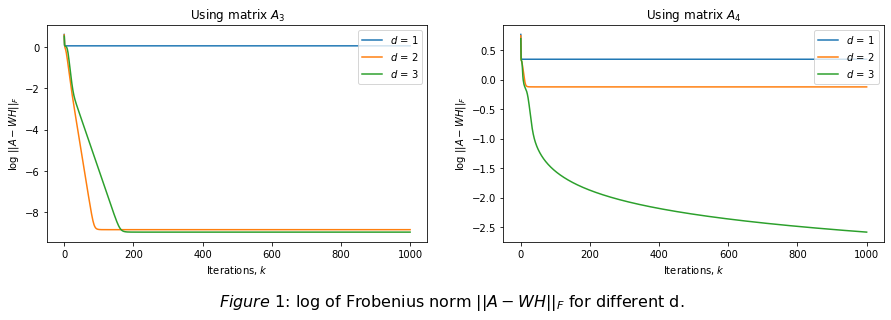

In [6]:
#g

"""
g) For A3 and A4, run the NMF algorithm for d = 1, d = 2 and d = 3 and
plot ∥A − WkHk∥F as a function of number of iterations in two separate plots
(one for A3 and one for A4). Scale the y-axis logarithmically, using for example
plt.semilogy. Is equation (17) satisfied? How do the results depend on d?
"""

d_vals = [1, 2, 3]
A3_error_arrays = []
A4_error_arrays = []
for d in d_vals:
    A3_error_arrays.append(NMF(A3, d)[2])
    A4_error_arrays.append(NMF(A4, d)[2])


    
### DETTE skal gjøres om til en generell plotfunksjon
fig, axs = plt.subplots(1, 2, figsize = (15, 4))
for i in range(len(d_vals)):
    axs[0].plot(np.log10(A3_error_arrays[i]), label = r"$d$ = " + f"{d_vals[i]}")
    axs[1].plot(np.log10(A4_error_arrays[i]), label = r"$d$ = " + f"{d_vals[i]}")

axs[0].set_title(r"Using matrix $A_3$")
axs[1].set_title(r"Using matrix $A_4$")

axs[0].legend(loc = "upper right")
axs[1].legend(loc = "upper right")

axs[0].set_xlabel(r"Iterations, $k$")
axs[0].set_ylabel(r"log $||A-WH||_F$")
axs[1].set_xlabel(r"Iterations, $k$")
axs[1].set_ylabel(r"log $||A-WH||_F$")


figure_count = 1
txt = f"$Figure$ ${figure_count}$: " + r"log of Frobenius norm $||A-WH||_F$ for different d."
plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize = 16)
plt.show()


## (TASK 2) Analysing the CryptoPunks dataset <a class="anchor" id="dataset"></a>

We will now turn our attention to image ... ...

The dataset for this project consists of 10 000 images. Of these we will sample $N=XXXX$ random images to ensure we get unique results. We use a predeterminded seed to ensure the results won't change if the notebook is restarted. The load_images function was handed out, but has been modified slightly to pick images before loading them into the notebook. 

In [7]:
def load_images(N, seed = 4269):
    """
    Loads N random images from cryptopunk dataset. Use the same seed to get the same
    selection each time. 
    Input:
        integer: N, number of images to load
        integer: seed for random sampling
    Output:
        array: faces, (24,24,4,N) numpy array containing images
    """
    # Allocate array to store images
    faces = np.zeros((24,24,4,N))

    # Chose N random image numbers
    M = 10000 # number of images to choose from
    np.random.seed(seed)
    image_number_choice = np.random.choice(np.arange(0, M),N, replace = False)
        
    # Iterate over folders
    for i in range(len(image_number_choice)):
        im_path = f"./imgs/imgs/imgs/{image_number_choice[i]}.png"
        im = cv2.imread(im_path, cv2.IMREAD_UNCHANGED)
        faces[:,:,:,i] = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)/255.0

    return faces

# Number of faces to keep in final array
N = 500

# Load N faces
faces = load_images(N)

# Check that the shape is correct
print("The face array has shape: ", faces.shape)

The face array has shape:  (24, 24, 4, 500)


Below is handed-out code for plotting the images we have loaded. 

In [8]:
def plotimgs(imgs, nplot = 8, rescale = False, filename = None, figsize = (16, 16)):
    """
    Plots nplot*nplot images on an nplot x nplot grid. 
    Saves to given filename if filename is given
    Can also rescale the RGB channels
    input:
        imgs: (24,24,4,N) or (24,24,3,N) array containing images, where N > nplot**2
        nplot: integer, nplot**2 images will be plotted
        rescale: bool
        filename: string, figure will be saved to this location. Should end with ".png".
    """
    # We will change some of the parameters of matplotlib, so we store the initial ones
    oldparams = plt.rcParams['figure.figsize']

    # New params to make better plot. There definitely exists better ways of doing this
    plt.rcParams['figure.figsize'] = figsize

    # Initialize subplots
    fig, axes = plt.subplots(nplot,nplot)

    # Set background color
    plt.gcf().set_facecolor("lightgrey")

    # Iterate over images
    for idx in range(nplot**2):
        
        # Indices
        i = idx//nplot; j = idx%nplot

        # Remove axis
        if nplot > 1:
            axes[i,j].axis('off')
        else:
            axes.axis('off')

        # Rescale RGB channels by dividing my maximal value
        if rescale:
            scaled_img = np.copy(imgs[:,:,:,idx])
            scaled_img[:,:,:3] = scaled_img[:,:,:3]/np.max(scaled_img[:,:,:3])
            if nplot > 1:
                axes[i,j].imshow(scaled_img)
            else:
                axes.imshow(scaled_img)
        else:
            if nplot > 1:
                axes[i,j].imshow(imgs[:,:,:,idx])
            else:
                axes.imshow(imgs[:,:,:])
    
    # Tight layout so images will appear closer together
    plt.tight_layout()

    # Save if filename is given
    if filename is not None:
        plt.savefig(filename)

    plt.show()

    # Return to old parameters
    plt.rcParams['figure.figsize'] = oldparams

**First look at the dataset**

2a) We now have all we need to investigate ...

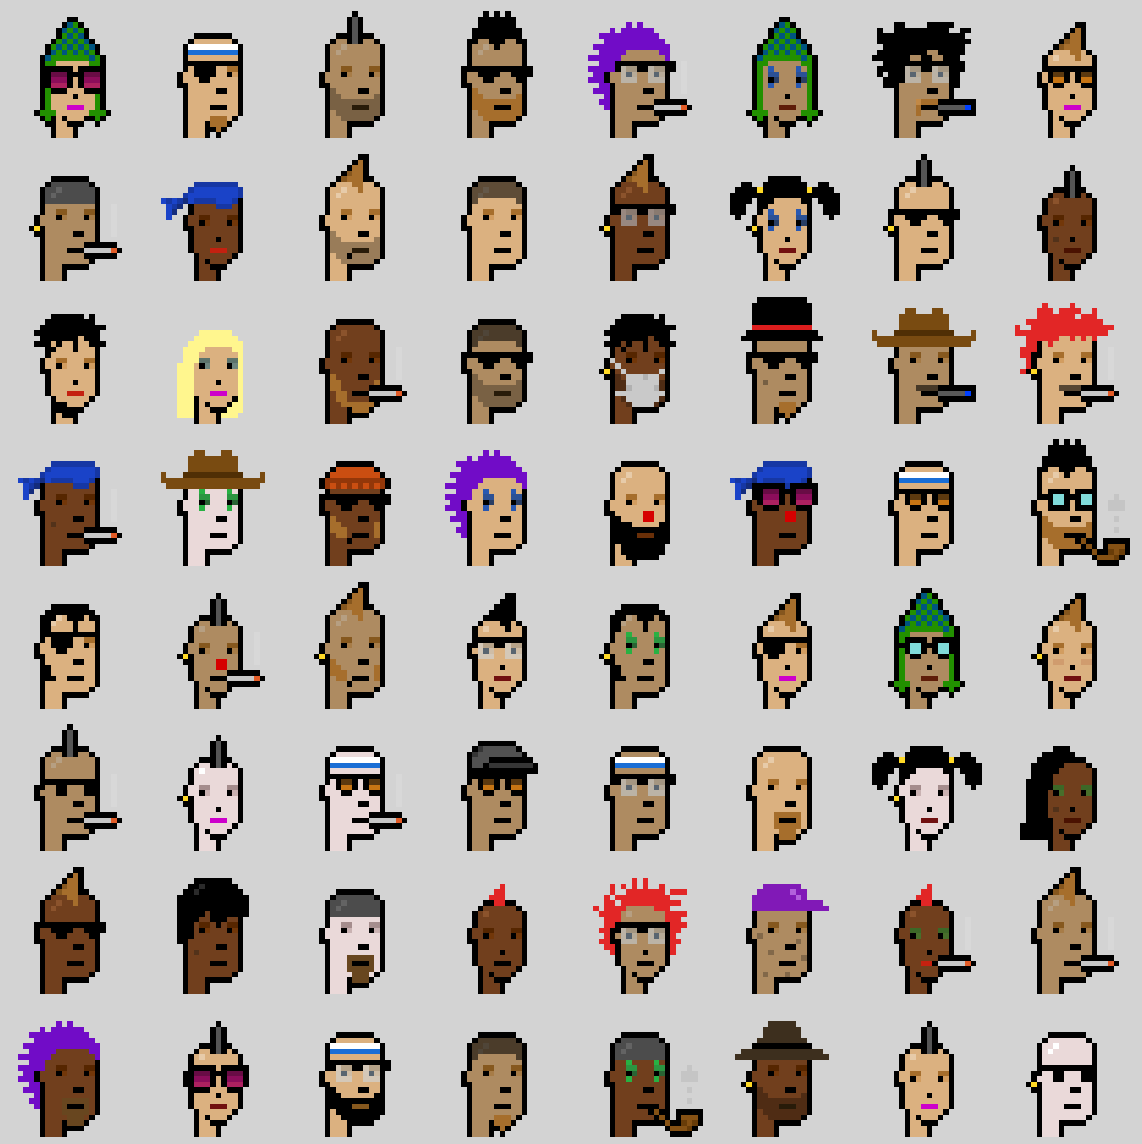

In [9]:
#2a)

# Example of plotting 8 times 8 images stored in "faces" and saving the output to a file named "punks.png"
plotimgs(faces, 8, filename="punks.png")

COMMENTs on 2a)

***Under er noe dere egentlig kan gjøre dere vil, men her viser vi hvordan dere kan splitte fargekanalene fra opasitetskanalen, samt reshape slik at dere har en array som dere kan anvende NMF på.***

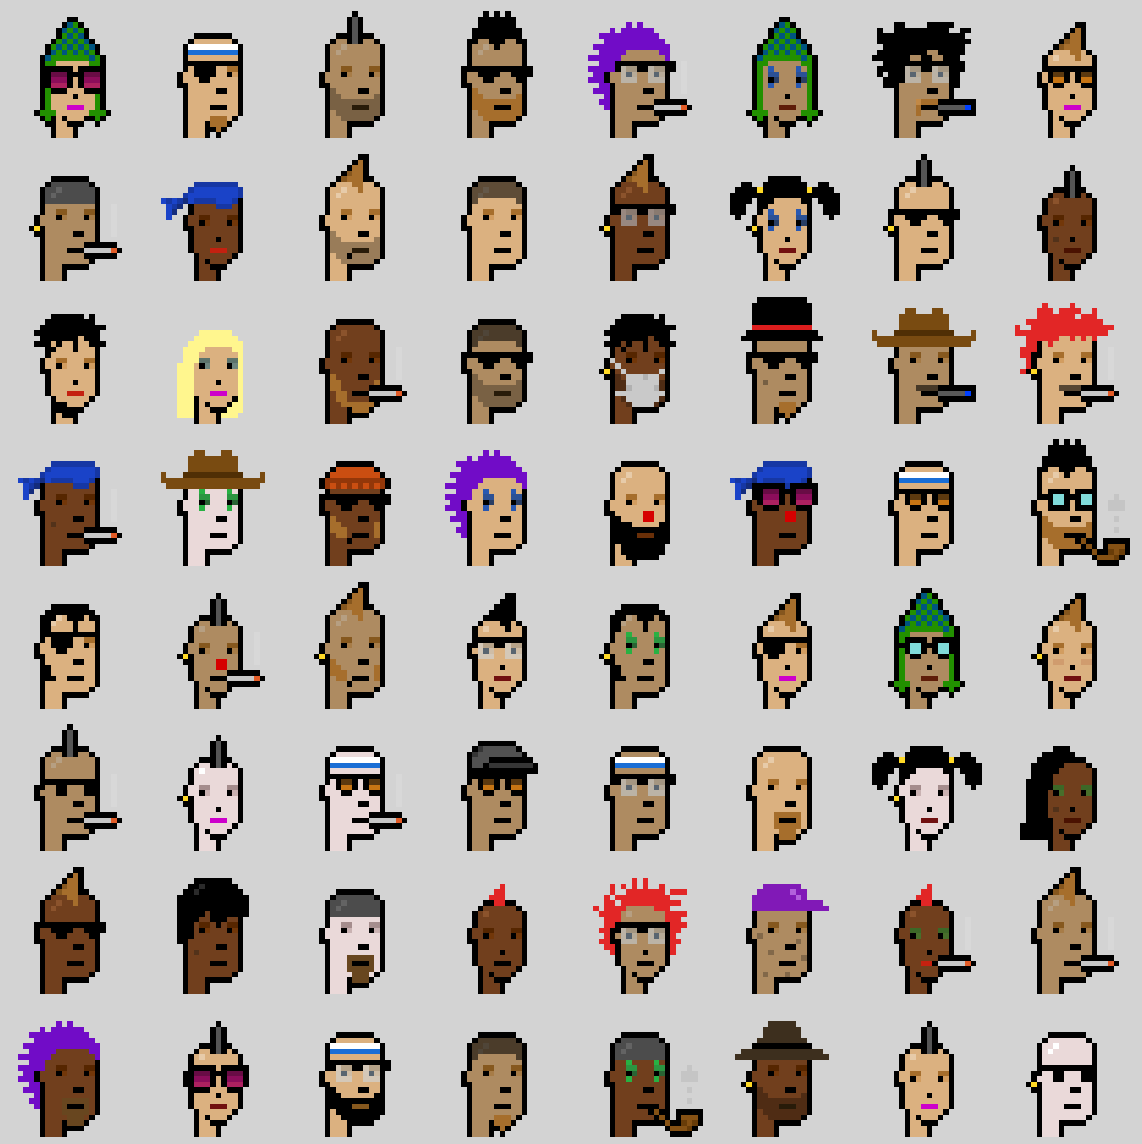

In [10]:
# Split the images into opacity and rgb channels
faces_opacity = faces[:,:,3,:]
faces_rgb = faces[:,:,:3,:]
shape = faces_rgb.shape


# Clever reshape "trick". This is the matrix we will apply the NMF to
faces_reshaped = faces_rgb.reshape(np.prod(shape)//N, N)


def split_and_reshape(faces):
    #input: 24x24x4xN array of stored images
    #output: 1728xN array of with rgb values for the images without opacity, 24x24x500 array of opacity for images 
    faces_opacity = faces[:,:,3,:]
    faces_rgb = faces[:,:,:3,:]
    shape = faces_rgb.shape
    
    # Clever reshape "trick". This is the matrix we will apply the NMF to
    faces_reshaped = faces_rgb.reshape(np.prod(shape)//N, N)
    return faces_reshaped, faces_opacity

def merge_and_reshape(reshaped, opacity = np.array([])):
    #input: 1728xN array of with rgb values for the images without opacity, 24x24xN array of opacity for images 
    #output: 24x24x4xN array of images
    N = int(reshaped.size/1728)
    faces = np.reshape(reshaped, (24,24,3,N))
    if opacity.size > 0:
        opacity = np.reshape(faces_opacity, (24,24,1,N))
        faces = np.concatenate((faces, opacity), axis=2)
    
    faces = np.where(faces<=1, faces, 1)
#     faces = np.where(faces>=0, faces, 0) # We won't need this (:
    
    return faces

faces_reshaped, opacity = split_and_reshape(faces)
jalla = merge_and_reshape(faces_reshaped, opacity)
plotimgs(jalla, 8, filename="punks.png")


We
\
\
\
\
\
\
\
\






**The *average* face**

2b) We first ... calculate mean ... usefull?

(24, 24, 4, 500)
(24, 24, 4)


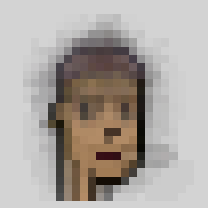

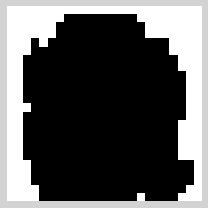

In [11]:
#2b) The mean face

print(faces.shape)
mean_face = np.mean(faces, axis = -1)
print(mean_face.shape)
plotimgs(mean_face, 1, filename="punks.png", figsize = (3, 3))


mean_face[:,:,0] = mean_face[:, :, 3] == 0
mean_face[:,:,1] = mean_face[:, :, 3] == 0
mean_face[:,:,2] = mean_face[:, :, 3] == 0
mean_face[:, :, 3] = 1
plotimgs(mean_face, 1, filename="punks.png", figsize = (3, 3)) # hvit betyr her gjennomsnitt lik 0

2b) 

Useful info?

Pixels with no opacity for all?

Rank of image matrix???

**NMF with $d=64$**

2c)

***c) Calculate the NMF of the 3 color channels as explained above using d = 64. Plot
the columns of W interpreted as RGB images (each columns should be a 24×24×3
vector so you can use the handed out plotting function after reshaping). Explain
and discuss what you see. Does the NMF capture the important features of the
dataset? You can also try with different values for d to see how this affects the
results.***

In [ ]:
#2c)

d = 64
faces_reshaped, opacity = split_and_reshape(faces)
W_2c, H_2c, err_2c = NMF(faces_reshaped, d, maxiter = 1000) # øke maxiter!!

## KUNNE vi brukt en bedre seed??
# seeds = [4269**i for i in range(5)]
# for i in tqdm(range(len(seeds)), leave = False):
#     seed = seeds[i] % 100
#     W_s, H_s, err_s = NMF(faces_reshaped, d, maxiter = 100, seed = seed)
#     plt.plot(err_s)
# plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
d = 64

W_columns = merge_and_reshape(W_2c) #np.reshape(W_2c, (24, 24, 3, d))
plotimgs(W_columns, 8, filename="punks.png", figsize = (12, 12))

2c) important features

In [ ]:
#2c) try with smaller and higher d

d = 16
W_16, H_16, err_16 = NMF(faces_reshaped, d, maxiter = 100) # øke maxiter!!
W_columns_16 = merge_and_reshape(W_16) 
plotimgs(W_columns_16, 4, filename=f"punks_basis_d={d}.png", figsize = (4, 4))

images_reborn_16 = merge_and_reshape(np.dot(W_16, H_16), opacity)
plotimgs(images_reborn_16, 4, filename=f"punks_d={d}.png", figsize = (4, 4))

d = 144
W_144, H_144, err_144 = NMF(faces_reshaped, d, maxiter = 100) # øke maxiter!!
W_columns_144 = merge_and_reshape(W_144) 
plotimgs(W_columns_144, 12, filename=f"punks_basis_d={d}.png", figsize = (12, 12))

images_reborn_144 = merge_and_reshape(np.dot(W_144, H_144), opacity)
plotimgs(images_reborn_144, 8, filename=f"punks_d={d}.png", figsize = (12, 12))



2c) What happens with other d

**Reconstructing the dataset**

2d) 

***d) With d = 64, calculate the 64 reconstructions W H corresponding to the images
you plotted in 2a) and plot the reconstructions (again, you can use the handed out
plotting function after reshaping). Are the reconstructions overall good? How do
the reconstructions deviate from the original images (if they deviate at all)? In
particular, are all features of the images equally well reconstructed?***

In [ ]:
#2d) reconstruct


images_reborn = merge_and_reshape(np.dot(W_2c, H_2c), opacity)
plotimgs(images_reborn, 8, filename="punks.png", figsize = (12, 12))



2d)

Discuss deviation

**Convergence**

2e) 

***e) For each iteration k, calculate ∥A−WkHk∥F and plot it as a function of iterations
similarily to what you did in Task 1, but now for d = 16, 32, 64. Are the results
reasonable? Does it look like the algorithm has converged?***

In [ ]:
#2e) 

d_vals = [16, 32, 64]
maxiter = 1000
image_error_arrays = []
for d in tqdm(d_vals, leave = False):
    image_error_arrays.append(NMF(faces_reshaped, d, maxiter = maxiter)[2]) # øke maxiter
    
### DETTE skal gjøres om til en generell plotfunksjon
fig, ax = plt.subplots(figsize = (15, 4))
for i in range(len(d_vals)):
    ax.plot(np.log10(image_error_arrays[i]), label = r"$d$ = " + f"{d_vals[i]}")

ax.legend(loc = "upper right")
ax.set_xlabel(r"Iterations, $k$")
ax.set_ylabel(r"log $||A-WH||_F$")

figure_count = 2
txt = f"$Figure$ ${figure_count}$: " + r"log of Frobenius norm $||A-WH||_F$ for different d for ........"
plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize = 16)
plt.show()



2e) discuss

**Reconstructing at different $d$**

2f) 

***f) For a wide range of d, for example d = 16, 64, 128, 256, do an NMF and calculate
∥A−W H∥F
9
. Make sure you are using a high number of maximum iterations (at
least 1000 iterations), and if your computing resources and time allows it, try to
use more values for d. Plot this quantity as a function of d. Discuss the resulting
plot. Specifically, how would you expect ∥A − W H∥F to depend on d?***

In [ ]:
#2f)

d_vals = [i**2 for i in range(2, 22)]
maxiter = 100
final_error = np.zeros(len(d_vals))
for i in tqdm(range(len(d_vals)), leave = False):
    final_error[i] = NMF(faces_reshaped, d_vals[i], maxiter = maxiter)[2][-1]
    
plt.plot(d_vals, final_error)



2f) discuss

## (Task 3) Denoising <a class="anchor" id="denoising"></a>

We will now add noise ...

We model the noise as:

$$A_{\textrm{noisy}} = A + \sigma E,$$

where $\sigma > 0 $ is our *noise level*, and $E$ sampled from $\mathcal{N}(0, 1)$.  

Below is the function ...

In [ ]:
def add_noise(imgs_reshaped, sigma = 0.1):
    """
    Adds gaussian noise to images as described in text.
    Note that imgs must be given as a (24*24*3, N) numpy array, i.e the reshaped images
    Input:
        imgs_reshaped: (1728,N) numpy array
        sigma: scalar, noise level
    Output:
        noisy_faces: (1728,N) numpy array containing noisy images
    """
    # Noise level
#     sigma = 0.1

    # Array that will store the rgb channels of the noisy images
    noisy_faces = np.copy(imgs_reshaped)

    # Number of noisy values we need
    nnzero = faces_reshaped[np.nonzero(imgs_reshaped)].shape[0]

    # Sample noisy values and add noise
    noise = np.random.normal(0.0,1,nnzero)
    noisy_faces[np.nonzero(imgs_reshaped)] += sigma*noise

    # Clip to lie between 0 and 1 so that we can still interpret them as images
    noisy_faces = np.maximum(0.0,np.minimum(1.0, noisy_faces))

    return noisy_faces

***Vi kan nå legge til støy til bildene våre, legge på opasitetskanalaen igjen og plotte. Dere må gjøre noe lignende etter dere har anvendt NMF og ønsker å plotte rekonstruksjoner med opasitet.***

3a)\ 
\
\
\
\
\



In [ ]:
faces_reshaped_noisy = add_noise(faces_reshaped, 0.2)

# Calculate the error of the noisy images
noise_residual = np.linalg.norm(faces_reshaped_noisy - faces_reshaped, 'fro') # SJEKK AT RIKTIG NORM?!?!?!?!?!?!?!?!?!?!?
print(noise_residual)

# For plotting noisy images we add the opacity
faces_noisy = merge_and_reshape(faces_reshaped_noisy, opacity)
plotimgs(faces_noisy)

**NMF -> ADD COOLER TITLEs**

3b) 

***• b) Using the same approach as task 2, fit an NMF using d = 64 to the noisy images.
Plot the columns of W and the reconstructions like you did in 2c) and 2d). Are
the reconstructions less noisy than the noisy images? Compare the columns of W
and the reconstructions to the results you got in task 2.***

In [ ]:
d = 64
W_noisy, H_noisy, err_noisy = NMF(faces_reshaped_noisy, d, maxiter = 100) # øke maxiter!!

W_columns_noisy = merge_and_reshape(W_noisy)
plotimgs(W_columns_noisy, 8, filename="punks_basis_noisy.png", figsize = (12, 12))

images_noisy_reborn = merge_and_reshape(np.dot(W_noisy, H_noisy), opacity)
plotimgs(images_noisy_reborn, 8, filename="punks.png", figsize = (12, 12))


**sss**

3c) 

***c) As you did in task 2, fit an NMF to the noisy images for a wide range of d,
calculate the reconstruction error ∥A − W H∥F (important: A is here the original
images, NOT the noisy images). Plot this with the error you calculated in 2f),
where noiseless images were used. If you have a large enough range of d and large
enough noise you should see that the reconstruction error for the noisy images
is somewhere between ”U”-shaped and ”L”-shaped, and at some point the error
should increase for large enough d. Explain why the plot looks like this (try to
include the words ”underfitting” and ”overfitting”). Approximately, what value of
d is the ”best fit”, that provides the lowest reconstruction error?***


In [ ]:
# BIG SIMULATION TIME

d_vals = [i**2 for i in range(2, 22)]
maxiter = 100
final_error_noisy = np.zeros(len(d_vals))
for i in tqdm(range(len(d_vals)), leave = False):
    W_n, H_n, err_n = NMF(faces_reshaped_noisy, d_vals[i], maxiter = maxiter)
    final_error_noisy[i] = np.linalg.norm(faces_reshaped - np.dot(W_n, H_n), 'fro')

plt.plot(d_vals, final_error_noisy, label = "noisy")
plt.plot(d_vals, final_error, label = "no noise")
plt.legend()

## SAVE DATA

We now load data ...

In [ ]:
# Load and plot!

Discuss

## Conclusion <a class="anchor" id="conclusion"></a>

3d) 

***d) Include a suitable conclusion to the entire project. What did you find? What
are the advantages and disadvantages of applying NMF for images, in particular
for denoising?***

Random

piss

på 

konk